# PART- 3 `( Handling Outliers )`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 150

In [2]:
df = pd.read_csv("filled_scout.csv")

## functions to fill the missing values

In [3]:
def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [4]:
def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [5]:
def fill(df, group_col1, group_col2, col_name, method): # method can be "mode" or "median" or "ffill"
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])
                
    elif method == "median":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].median()).fillna(df[cond1][col_name].median()).fillna(df[col_name].median())
                
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [6]:
df.shape

(15919, 26)

In [7]:
df.head(1).T

,0
make_model,Audi A1
body_type,Sedans
price,15770
vat,VAT deductible
km,56013.000
Type,Used
Fuel,Diesel
Gears,7.000
Comfort_Convenience,"Air conditioning,Armrest,Automatic climate con..."
Entertainment_Media,"Bluetooth,Hands-free equipment,On-board comput..."


## km

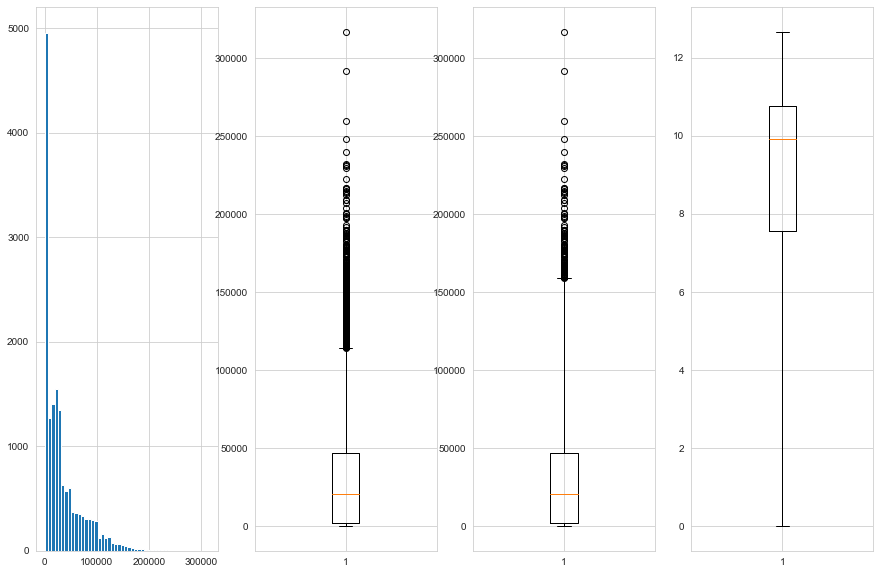

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.hist(df.km, bins = 50)

plt.subplot(142)
plt.boxplot(df.km)

plt.subplot(143)
plt.boxplot(df.km, whis = 2.5)

plt.subplot(144)
plt.boxplot(np.log(df.km), whis = 2.5)
plt.show()

In [9]:
#df["km_logged"] = np.log(df.km)

km is a variable with a wide range of values. We can not consider the outlier values above as a real outliers. So let's keep it as it is.

## cons_comb

In [10]:
df.cons_comb.describe()

count   15919.000
mean        4.832
std         0.868
min         3.000
25%         4.100
50%         4.800
75%         5.400
max         9.100
Name: cons_comb, dtype: float64

In [11]:
df.cons_comb.sort_values().head(10)

6440    3.000
2863    3.000
2862    3.000
13493   3.000
13482   3.000
11004   3.000
11015   3.000
11044   3.000
811     3.000
6240    3.000
Name: cons_comb, dtype: float64

In [12]:
df.cons_comb.sort_values().tail(10)

3601    8.300
3649    8.300
10789   8.600
12553   8.600
12530   8.600
12422   8.600
10817   8.700
12054   8.700
12529   8.700
10771   9.100
Name: cons_comb, dtype: float64

Using our domain knowledge we can conclude that min value of 3 and max value of 9.10 are normal. But anyways, let's analyze outliers with plotting, np.log and winsorize methods.

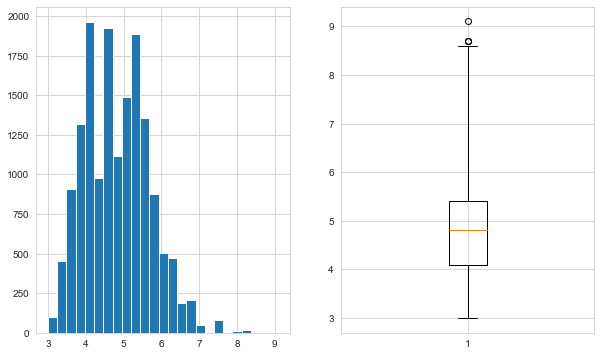

In [13]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.hist(df.cons_comb, bins = 25)

plt.subplot(122)
plt.boxplot(df.cons_comb, whis = 2.5)

plt.show()

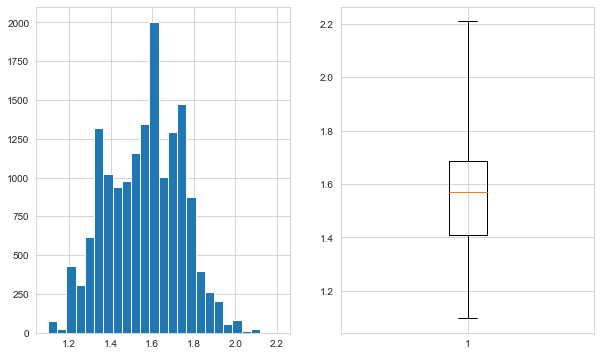

In [14]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.hist(np.log(df.cons_comb), bins = 25)

plt.subplot(122)
plt.boxplot(np.log(df.cons_comb), whis = 2)

plt.show()

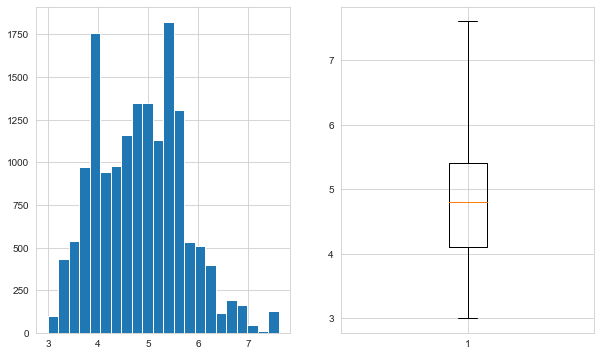

In [15]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.hist(winsorize(df.cons_comb, (0.003)), bins = 22)

plt.subplot(122)
plt.boxplot(winsorize(df.cons_comb, (0.003)), whis = 2)

plt.show()

## displacement_cc

In [16]:
df.Displacement_cc.describe()

count   15919.000
mean     1425.609
std       329.720
min         1.000
25%      1229.000
50%      1461.000
75%      1598.000
max     16000.000
Name: Displacement_cc, dtype: float64

In [17]:
df.sort_values(by = ["Displacement_cc"], ascending = False)["Displacement_cc"].head(55)

10932   16000.000
7169    15898.000
10771    2967.000
3595     2480.000
3587     2480.000
3649     2480.000
3590     2480.000
3599     2480.000
3598     2480.000
3596     2480.000
3600     2480.000
3601     2480.000
3610     2480.000
3609     2480.000
3608     2480.000
3606     2480.000
3605     2480.000
3648     2480.000
3592     2480.000
3593     2480.000
3602     2480.000
3604     2480.000
3603     2480.000
12176    2000.000
12462    2000.000
12521    2000.000
12170    2000.000
13027    2000.000
11929    2000.000
12179    2000.000
11935    2000.000
12181    2000.000
11800    2000.000
4188     2000.000
12526    2000.000
12959    2000.000
12527    2000.000
11977    2000.000
12469    2000.000
12520    2000.000
12464    2000.000
12265    2000.000
11870    2000.000
10556    2000.000
2903     2000.000
15197    2000.000
12414    2000.000
11988    2000.000
13050    2000.000
12412    2000.000
10464    2000.000
12560    2000.000
12411    2000.000
11032    2000.000
13054    2000.000
Name: Disp

In [18]:
df.sort_values(by = ["Displacement_cc"], ascending = True)["Displacement_cc"].head(55)

12790     1.000
14319     1.000
14315     1.000
12849     1.000
12848     1.000
12835     1.000
12823     1.000
12815     1.000
12800     1.000
12798     1.000
12796     1.000
12786     1.000
12783     1.000
12781     1.000
12769     1.000
12768     1.000
12750     1.000
12670     1.000
12604     1.000
12554     1.000
12501     1.000
12499     1.000
12484     1.000
12473     1.000
12467     1.000
14284     1.000
14320     1.000
14321     1.000
14314     1.000
14322     1.000
14328     1.000
14327     1.000
13904     1.000
14325     1.000
14326     1.000
14324     1.000
10559     2.000
14198     2.000
13912    54.000
10194   122.000
7810    139.000
7812    139.000
7811    139.000
7809    139.000
8128    140.000
15578   160.000
15576   160.000
15574   160.000
15575   160.000
15577   160.000
15579   160.000
13653   890.000
14694   898.000
14342   898.000
14695   898.000
Name: Displacement_cc, dtype: float64

In [19]:
outlier_bool_list = df.Displacement_cc.isin([1, 2, 54, 122, 139, 140, 160, 16000, 15898])

In [20]:
outlier_bool_list

0        False
1        False
2        False
3        False
4        False
         ...  
15914    False
15915    False
15916    False
15917    False
15918    False
Name: Displacement_cc, Length: 15919, dtype: bool

In [21]:
df.loc[outlier_bool_list, "Displacement_cc"] = np.nan

In [22]:
fill(df, "make_model", "body_type", "Displacement_cc", "mode")

Number of NaN :  0
------------------
1598.000    5077
999.000     2467
1398.000    1388
1399.000     772
1461.000     682
1229.000     678
1956.000     670
1490.000     559
1422.000     467
1197.000     372
898.000      351
1395.000     320
1968.000     301
1149.000     288
1618.000     212
1798.000     210
1498.000     196
1600.000     130
1248.000     110
1997.000     103
1364.000     102
1400.000      90
998.000       72
1500.000      50
2000.000      46
1000.000      40
1998.000      25
2480.000      20
1984.000      18
1200.000      18
899.000       11
1397.000      11
929.000        5
1499.000       5
997.000        4
900.000        4
1596.000       4
1396.000       3
1599.000       3
1199.000       3
1589.000       2
1495.000       2
995.000        2
1300.000       2
1496.000       1
1584.000       1
996.000        1
973.000        1
1533.000       1
1239.000       1
1368.000       1
1333.000       1
1369.000       1
1568.000       1
1686.000       1
1856.000       1
1896.000  

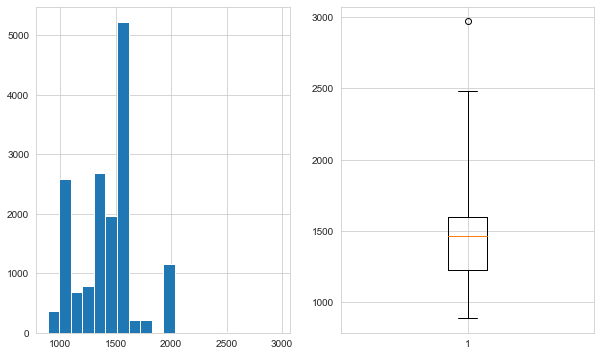

In [23]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(df.Displacement_cc, bins = 20)

plt.subplot(122)
plt.boxplot(df.Displacement_cc, whis = 2.5)

plt.show()

- There is no problem in terms of outliers

## Nr_of_Doors

In [24]:
df.Nr_of_Doors.value_counts(dropna = False)

5.000    11787
4.000     3079
3.000      832
2.000      219
7.000        1
1.000        1
Name: Nr_of_Doors, dtype: int64

In [25]:
df.Nr_of_Doors.replace([1, 7], np.nan, inplace=True)

In [26]:
df.Nr_of_Doors.value_counts(dropna = False)

5.000    11787
4.000     3079
3.000      832
2.000      219
nan          2
Name: Nr_of_Doors, dtype: int64

In [27]:
fill(df, "make_model", "body_type", "Nr_of_Doors", "mode")

Number of NaN :  0
------------------
5.000    11789
4.000     3079
3.000      832
2.000      219
Name: Nr_of_Doors, dtype: int64


<AxesSubplot:>

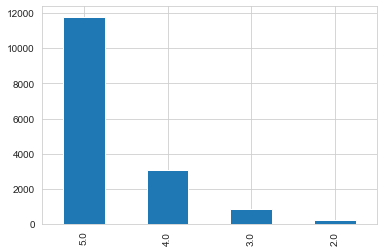

In [28]:
df.Nr_of_Doors.value_counts(dropna = False).plot.bar()

<AxesSubplot:xlabel='make_model,Nr_of_Doors'>

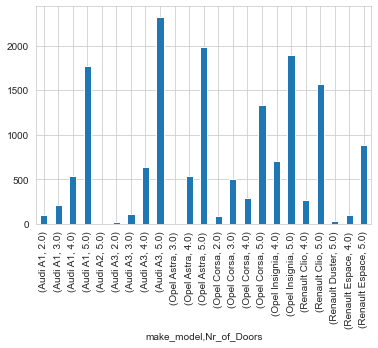

In [29]:
df.groupby(["make_model", "Nr_of_Doors"]).Nr_of_Doors.count().plot.bar()

In [30]:
df.drop("Nr_of_Doors", axis=1, inplace=True)

## Nr_of_Seats

In [31]:
df.Nr_of_Seats.value_counts(dropna = False)

5.000    14308
4.000     1127
7.000      362
2.000      119
6.000        2
3.000        1
Name: Nr_of_Seats, dtype: int64

In [32]:
df.Nr_of_Seats.replace([3, 6], np.nan, inplace=True)

In [33]:
df.Nr_of_Seats.value_counts(dropna = False)

5.000    14308
4.000     1127
7.000      362
2.000      119
nan          3
Name: Nr_of_Seats, dtype: int64

In [34]:
fill(df, "make_model", "body_type", "Nr_of_Seats", "mode")

Number of NaN :  0
------------------
5.000    14311
4.000     1127
7.000      362
2.000      119
Name: Nr_of_Seats, dtype: int64


<AxesSubplot:>

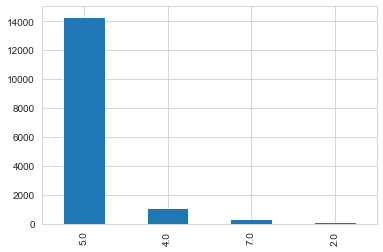

In [35]:
df.Nr_of_Seats.value_counts(dropna = False).plot.bar()

<AxesSubplot:xlabel='make_model,Nr_of_Seats'>

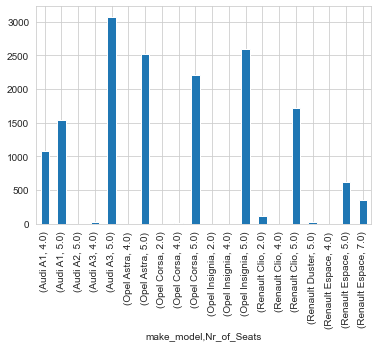

In [36]:
df.groupby(["make_model", "Nr_of_Seats"]).Nr_of_Seats.count().plot.bar()

In [37]:
df.drop("Nr_of_Seats", axis=1, inplace=True)

## Weight_kg

In [38]:
df.Weight_kg.describe()

count   15919.000
mean     1337.432
std       200.466
min         1.000
25%      1165.000
50%      1295.000
75%      1472.000
max      2471.000
Name: Weight_kg, dtype: float64

In [39]:
df["Weight_kg"].sort_values().head(10)

8355      1.000
12779     1.000
1143    102.000
8857    840.000
14313   900.000
13513   977.000
13555   977.000
14654   980.000
14105   980.000
13999   980.000
Name: Weight_kg, dtype: float64

In [40]:
df["Weight_kg"].replace([1, 102], np.nan, inplace = True)

In [41]:
df["Weight_kg"].isnull().sum()

3

In [42]:
fill(df, "make_model", "body_type", "Weight_kg", "mode")

Number of NaN :  0
------------------
1163.000    1583
1360.000    1419
1487.000     967
1135.000     837
1425.000     744
1180.000     695
1273.000     656
1165.000     603
1503.000     561
1734.000     556
1087.000     291
1335.000     242
1365.000     211
1199.000     205
1350.000     156
1119.000     153
1355.000     136
1280.000     127
1260.000     127
1275.000     112
1278.000     110
1255.000     108
1200.000     107
1522.000     103
1659.000     102
1195.000      96
1120.000      93
1403.000      91
1701.000      87
1250.000      85
1685.000      83
1441.000      82
1285.000      80
1308.000      80
1110.000      75
1613.000      75
1279.000      72
1364.000      70
1345.000      67
1733.000      65
1071.000      64
1325.000      64
1141.000      64
1209.000      64
1230.000      63
1845.000      56
1090.000      54
1052.000      53
1664.000      52
1154.000      52
1513.000      51
1065.000      50
1237.000      49
1205.000      46
1088.000      46
1440.000      46
1265.000  

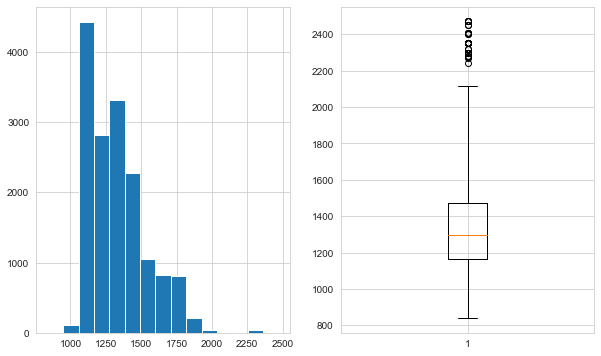

In [43]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(df.Weight_kg, bins=15)

plt.subplot(122)
plt.boxplot(df.Weight_kg, whis=2.5)

plt.show()

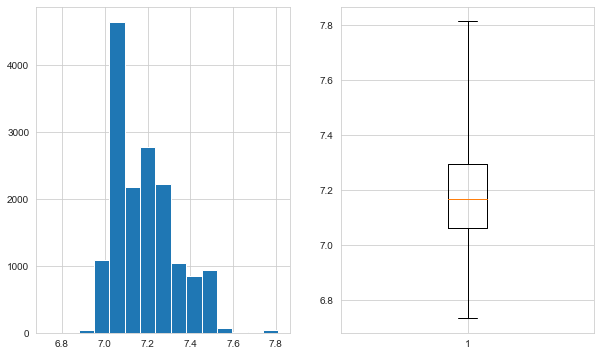

In [44]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(np.log(df.Weight_kg), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.Weight_kg), whis=2.5)

plt.show()

## hp_kW

In [45]:
df.hp_kW.describe()

count   15919.000
mean       88.374
std        26.844
min         1.000
25%        66.000
50%        85.000
75%       101.000
max       294.000
Name: hp_kW, dtype: float64

In [46]:
df.hp_kW.sort_values().head(50)

6034     1.000
6946     1.000
7014     1.000
9285     1.000
9287     1.000
6005     1.000
9288     1.000
7018     1.000
9289     1.000
9290     1.000
9292     1.000
9299     1.000
10610    1.000
10580    1.000
10579    1.000
10468    1.000
15155    1.000
15156    1.000
7019     1.000
7016     1.000
13885    4.000
3913     9.000
8857    40.000
13759   40.000
8408    44.000
10282   51.000
10283   51.000
10284   51.000
10285   51.000
10286   51.000
10287   51.000
9145    51.000
10288   51.000
10346   51.000
10281   51.000
10330   51.000
9026    51.000
9025    51.000
10342   51.000
10289   51.000
9159    51.000
9384    51.000
9158    51.000
10290   51.000
10291   51.000
10345   51.000
10280   51.000
10279   51.000
10278   51.000
10264   51.000
Name: hp_kW, dtype: float64

In [47]:
df.hp_kW.unique()

array([ 66., 141.,  85.,  70.,  92., 112.,  60.,  71.,  67., 110.,  93.,
       147.,  86., 140.,  87.,  81.,  82., 135., 132., 100.,  96., 162.,
       150., 294., 228., 270., 137.,   9., 133.,  77., 101.,  78., 103.,
         1.,  74., 118.,  84.,  88.,  80.,  76., 149.,  51.,  44.,  55.,
        52.,  63.,  40.,  65.,  75., 125., 120., 184., 239., 121., 143.,
       191.,  89., 195., 127., 122., 154., 155., 104., 123., 146.,  90.,
        56.,  53.,  54., 164.,   4., 163.,  57., 119., 165., 117., 115.,
        98., 168., 167.])

In [48]:
df.hp_kW.loc[df.hp_kW < 40] = np.nan

In [49]:
df.hp_kW.isnull().sum()

22

In [50]:
fill(df, "make_model", "body_type", "hp_kW", "mode")

Number of NaN :  0
------------------
85.000     2544
66.000     2124
81.000     1403
100.000    1317
110.000    1117
70.000      890
125.000     715
51.000      703
55.000      589
118.000     552
92.000      466
121.000     392
147.000     380
77.000      353
56.000      295
54.000      276
103.000     253
87.000      232
165.000     194
88.000      177
60.000      160
162.000      98
74.000       81
96.000       72
71.000       59
101.000      47
67.000       40
154.000      39
122.000      35
119.000      30
164.000      27
135.000      24
82.000       22
52.000       22
78.000       20
146.000      18
294.000      18
141.000      16
57.000       10
120.000       8
104.000       8
112.000       7
191.000       7
117.000       6
155.000       6
184.000       5
65.000        4
90.000        4
76.000        4
93.000        3
149.000       3
168.000       3
80.000        3
98.000        3
143.000       2
270.000       2
127.000       2
167.000       2
140.000       2
150.000       2
40

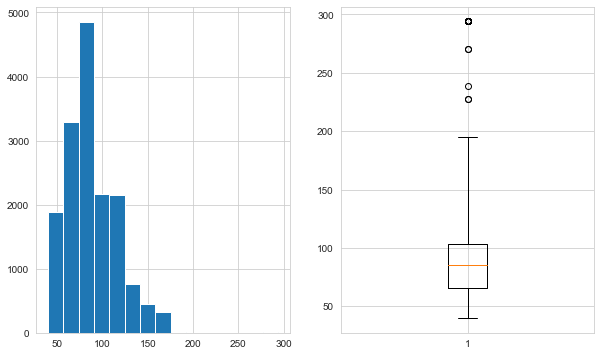

In [51]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(df.hp_kW, bins=15)

plt.subplot(122)
plt.boxplot(df.hp_kW, whis=2.5)

plt.show()

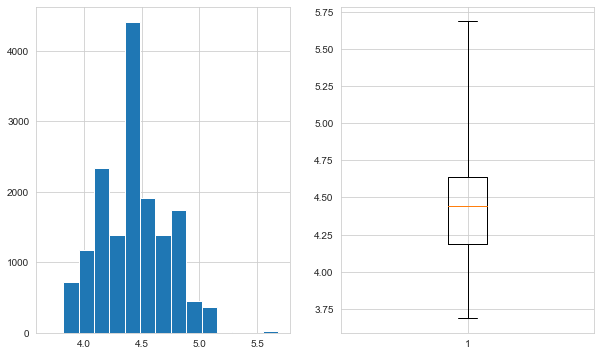

In [52]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(np.log(df.hp_kW), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.hp_kW), whis=2.5)

plt.show()

## CO2_Emission

In [53]:
df.CO2_Emission.describe()

count   15919.000
mean      110.672
std        33.844
min         0.000
25%       104.000
50%       116.000
75%       128.000
max       990.000
Name: CO2_Emission, dtype: float64

In [54]:
df.CO2_Emission.value_counts().sort_index()

0.000        2
1.000       84
1.060        1
5.000        3
8.000       25
9.000      198
10.000     477
11.000     171
12.087       3
12.324       1
13.000     100
13.983       1
14.000      59
14.457       1
15.000      28
16.000       2
17.000      25
36.000       3
45.000       1
51.000       1
80.000       1
84.000       2
85.000     275
87.000       6
88.000      15
89.000      19
90.000      54
91.000      31
93.000      66
94.000      37
95.000     161
96.000      22
97.000     539
98.000     366
99.000     546
100.000     36
101.000    105
103.000    445
104.000    679
105.000    202
106.000    674
107.000    362
108.000    362
109.000    234
110.000    289
111.000    237
112.500      1
113.000    235
114.000    556
115.000     86
116.000    157
116.500      3
117.000    460
118.000    314
118.500    147
119.000    361
120.000    836
121.000     82
123.000    410
124.000    516
125.000    133
126.000    284
127.000    257
128.000    329
129.000    333
130.000    189
131.000   

In [55]:
df.groupby(["make_model", "body_type","CO2_Emission"]).price.describe()

count      mean       std  \
make_model     body_type     CO2_Emission                               
Audi A1        Compact       1.000          1.000 20881.000       nan   
                             9.000          1.000 12479.000       nan   
                             10.000       147.000 16946.871  2850.063   
                             11.000        25.000 19960.360  2676.262   
                             14.000         2.000 28750.000   268.701   
                             90.000         1.000 12880.000       nan   
                             91.000         5.000 13038.000  1108.927   
                             94.000         5.000 13960.000  1232.071   
                             97.000       113.000 15449.593  2445.755   
                             98.000        33.000 16574.364  2637.087   
                             99.000        19.000 16043.947  2257.403   
                             100.000        4.000 16127.500  1583.401   
                             103.000       30.000 21233.033  1794.551   
                             104.000      218.000 17712.234  3766.508   
                             105.000       14.000 22234.857   812.264   
                             106.000       43.000 19831.791  3335.793   
                             107.000       13.000 16527.692  1620.412   
                             108.000       42.000 23587.095  3375.693   
                             109.000       34.000 17029.324  2514.314   
                             110.000       51.000 26340.373  2434.738   
                             111.000      138.000 23765.283  3477.921   
                             113.000        5.000 20388.000  2796.188   
                             114.000        1.000 15490.000       nan   
                             115.000        7.000 24067.857  6950.650   
                             116.000       20.000 23580.950  2813.103   
                             117.000        8.000 19094.875  2942.954   
                             118.000        2.000 13615.000    91.924   
                             119.000        1.000 12550.000       nan   
                             120.000       27.000 15850.000     0.000   
                             121.000        2.000 18710.000  3224.407   
                             123.000       17.000 19308.647  3816.070   
                             126.000        1.000 19999.000       nan   
                             127.000        2.000 19888.000     0.000   
                             134.000        2.000 22495.000   841.457   
                             136.000        2.000 29088.000   128.693   
                             137.000        2.000 28660.000   282.843   
                             331.000        1.000 12990.000       nan   
               Coupe         97.000         2.000 14925.000  1378.858   
               Sedans        9.000         42.000 15764.548  1578.276   
                             10.000       198.000 17497.909  2518.189   
                             11.000        42.000 19247.595  2058.248   
                             89.000         4.000 16572.500   288.141   
                             90.000         3.000 14396.333   532.382   
                             91.000        14.000 14228.500  1438.927   
                             94.000        12.000 15710.000  2522.329   
                             95.000         2.000 13070.000  2305.168   
                             97.000       315.000 14905.857  1996.270   
                             98.000       281.000 19054.840  4194.046   
                             99.000       101.000 16177.218  2115.764   
                             100.000        3.000 14490.000     0.000   
                             101.000        5.000 19228.000  1683.574   
                             103.000       10.000 17725.000  3092.084   
                             104.000       88.000 18441.466  3010.822   
                             

In [56]:
cond = ((df.CO2_Emission < 52) | (df.CO2_Emission > 330))
df.loc[cond, "CO2_Emission"] = np.nan

In [57]:
df.CO2_Emission.isnull().sum()

1188

In [58]:
fill(df, "make_model", "body_type", "CO2_Emission", "median")

Number of NaN :  0
------------------
120.000    842
99.000     828
106.000    756
104.000    681
139.000    633
114.000    630
117.000    598
124.000    559
97.000     539
103.000    453
129.000    434
123.000    430
105.000    379
98.000     366
107.000    362
108.000    362
119.000    361
118.000    357
133.000    348
128.000    329
110.000    297
126.000    284
85.000     275
127.000    257
111.000    237
113.000    235
109.000    234
118.500    221
140.000    221
135.000    202
130.000    189
150.000    174
143.000    171
95.000     161
116.000    157
141.000    156
136.000    145
137.000    135
125.000    133
134.000    130
145.000    126
149.000    117
153.000    113
147.000    109
101.000    105
115.000     86
121.000     82
138.000     75
93.000      66
168.000     58
90.000      54
131.000     48
148.000     48
154.000     40
144.000     40
94.000      37
100.000     36
146.000     36
151.000     34
186.000     32
91.000      31
187.000     26
96.000      22
89.000      19
18

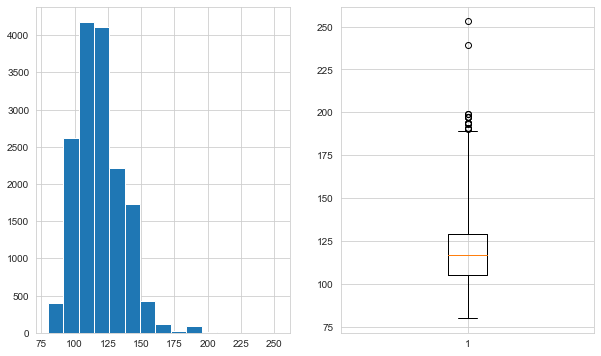

In [59]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(df.CO2_Emission, bins=15)

plt.subplot(122)
plt.boxplot(df.CO2_Emission, whis=2.5)

plt.show()

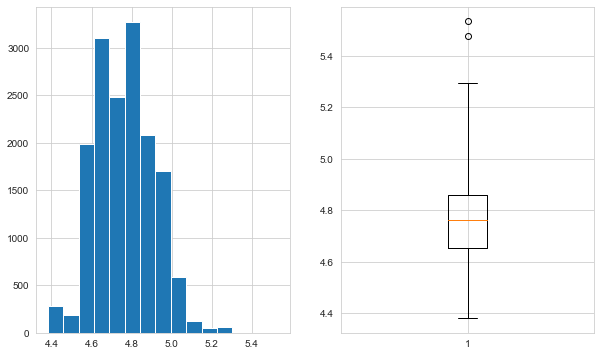

In [60]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(np.log(df.CO2_Emission), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.CO2_Emission), whis=2.5)

plt.show()

## price

In [61]:
df.price.describe()

count   15919.000
mean    18019.897
std      7386.169
min        13.000
25%     12850.000
50%     16900.000
75%     21900.000
max     74600.000
Name: price, dtype: float64

In [62]:
df.price.sort_values().head(5)

8594      13
8828     120
6066     255
8829     331
8827    4950
Name: price, dtype: int64

In [63]:
df.drop(index = [8594, 8828, 6066,8829], axis = 0, inplace = True)

In [64]:
df.reset_index(drop = True, inplace = True)

In [65]:
df.shape

(15915, 24)

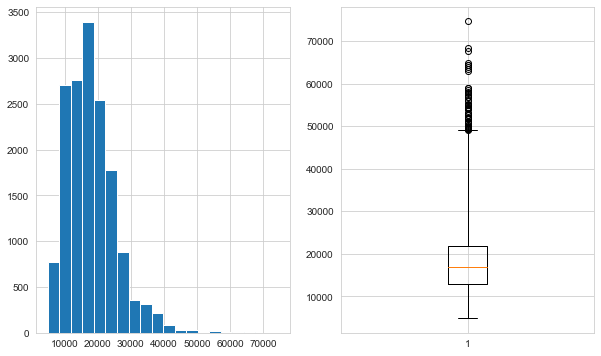

In [66]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

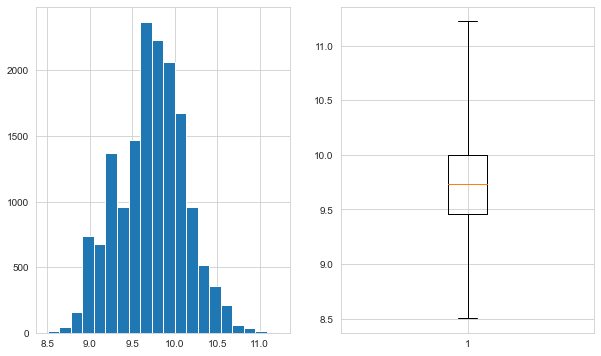

In [67]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(np.log(df.price), bins=20)

plt.subplot(122)
plt.boxplot(np.log(df.price), whis=2.3)

plt.show()

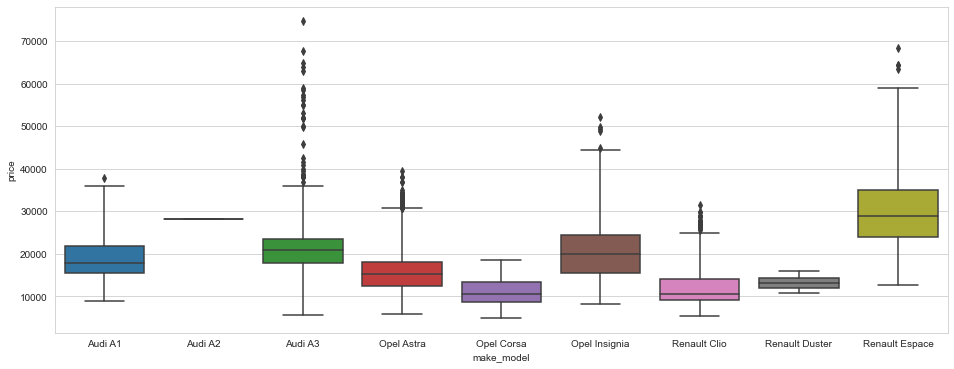

In [68]:
plt.figure(figsize=(16,6))
sns.boxplot(x="make_model", y="price", data=df, whis=2.3)
plt.show()

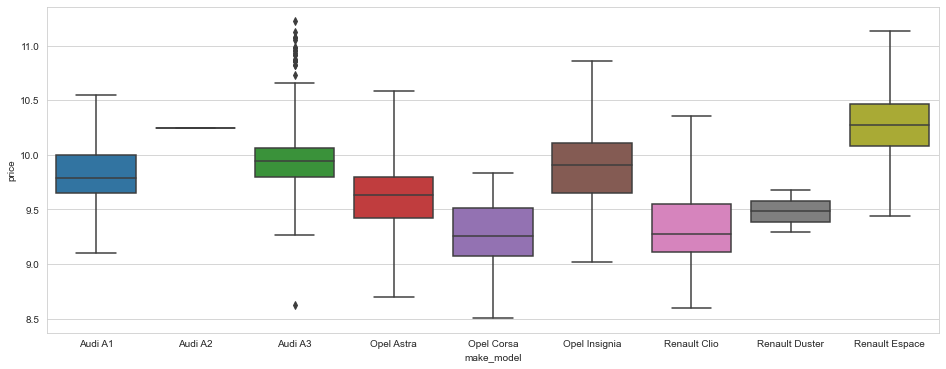

In [69]:
plt.figure(figsize=(16,6))
sns.boxplot(x="make_model", y=np.log(df.price), data=df, whis=2.3)
plt.show()

## make_model

In [70]:
df[df.make_model=="Audi A2"]

,make_model,body_type,price,vat,km,Type,Fuel,Gears,Comfort_Convenience,Entertainment_Media,Extras,Safety_Security,age,Previous_Owners,hp_kW,Inspection_new,Paint_Type,Upholstery_type,Gearing_Type,Displacement_cc,Weight_kg,Drive_chain,cons_comb,CO2_Emission
2614,Audi A2,Off-Road,28200,VAT deductible,26166.000,Employee's car,Diesel,6.000,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,MP3,O...",Alloy wheels,"ABS,Adaptive Cruise Control,Central door lock,...",1.000,1.000,85.000,0,Metallic,Cloth,Manual,1598.000,1135.000,front,4.900,114.000


In [71]:
df.drop(index = [2614], inplace = True)

In [72]:
df.reset_index(drop = True, inplace = True)

In [73]:
df.shape

(15914, 24)

## Final_Step

In [74]:
df.head(3).T

,0,1,2
make_model,Audi A1,Audi A1,Audi A1
body_type,Sedans,Sedans,Sedans
price,15770,14500,14640
vat,VAT deductible,Price negotiable,VAT deductible
km,56013.000,80000.000,83450.000
Type,Used,Used,Used
Fuel,Diesel,Benzine,Diesel
Gears,7.000,7.000,7.000
Comfort_Convenience,"Air conditioning,Armrest,Automatic climate con...","Air conditioning,Automatic climate control,Hil...","Air conditioning,Cruise control,Electrical sid..."
Entertainment_Media,"Bluetooth,Hands-free equipment,On-board comput...","Bluetooth,Hands-free equipment,On-board comput...","MP3,On-board computer"


In [75]:
numeric_col = "price,km,Gears,Previous_Owners,cons_comb,Displacement_cc,age,hp_kW,Weight_kg,CO2_Emission".split(",")

In [76]:
df_num = df[numeric_col]

In [77]:
df_num

,price,km,Gears,Previous_Owners,cons_comb,Displacement_cc,age,hp_kW,Weight_kg,CO2_Emission
0,15770,56013.000,7.000,2.000,3.800,1422.000,3.000,66.000,1220.000,99.000
1,14500,80000.000,7.000,1.000,5.600,1798.000,2.000,141.000,1255.000,129.000
2,14640,83450.000,7.000,1.000,3.800,1598.000,3.000,85.000,1135.000,99.000
3,14500,73000.000,6.000,1.000,3.800,1422.000,3.000,66.000,1195.000,99.000
4,16790,16200.000,7.000,1.000,4.100,1422.000,3.000,66.000,1135.000,109.000
...,...,...,...,...,...,...,...,...,...,...
15909,39950,1647.363,6.000,1.000,5.300,1997.000,0.000,147.000,1758.000,139.000
15910,39885,9900.000,7.000,1.000,7.400,1798.000,0.000,165.000,1708.000,168.000
15911,39875,15.000,6.000,1.000,5.300,1997.000,0.000,146.000,1734.000,139.000
15912,39700,10.000,6.000,1.000,5.300,1997.000,0.000,147.000,1758.000,139.000


<AxesSubplot:>

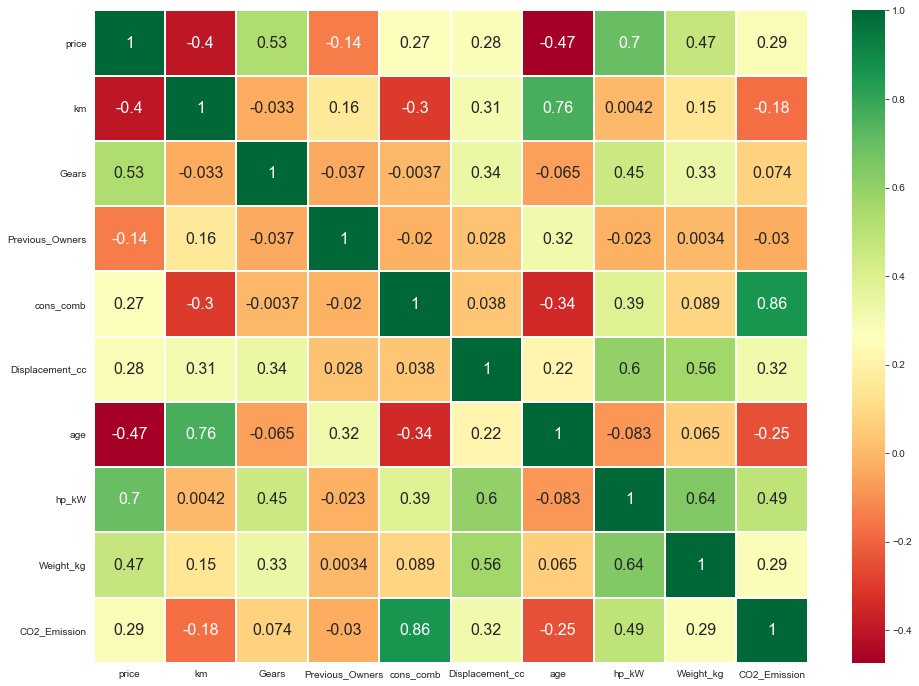

In [78]:
plt.figure(figsize = (16,12))
sns.heatmap(df_num.corr(), annot = True, cmap="RdYlGn", linewidths=0.2, annot_kws = {"size": 16})

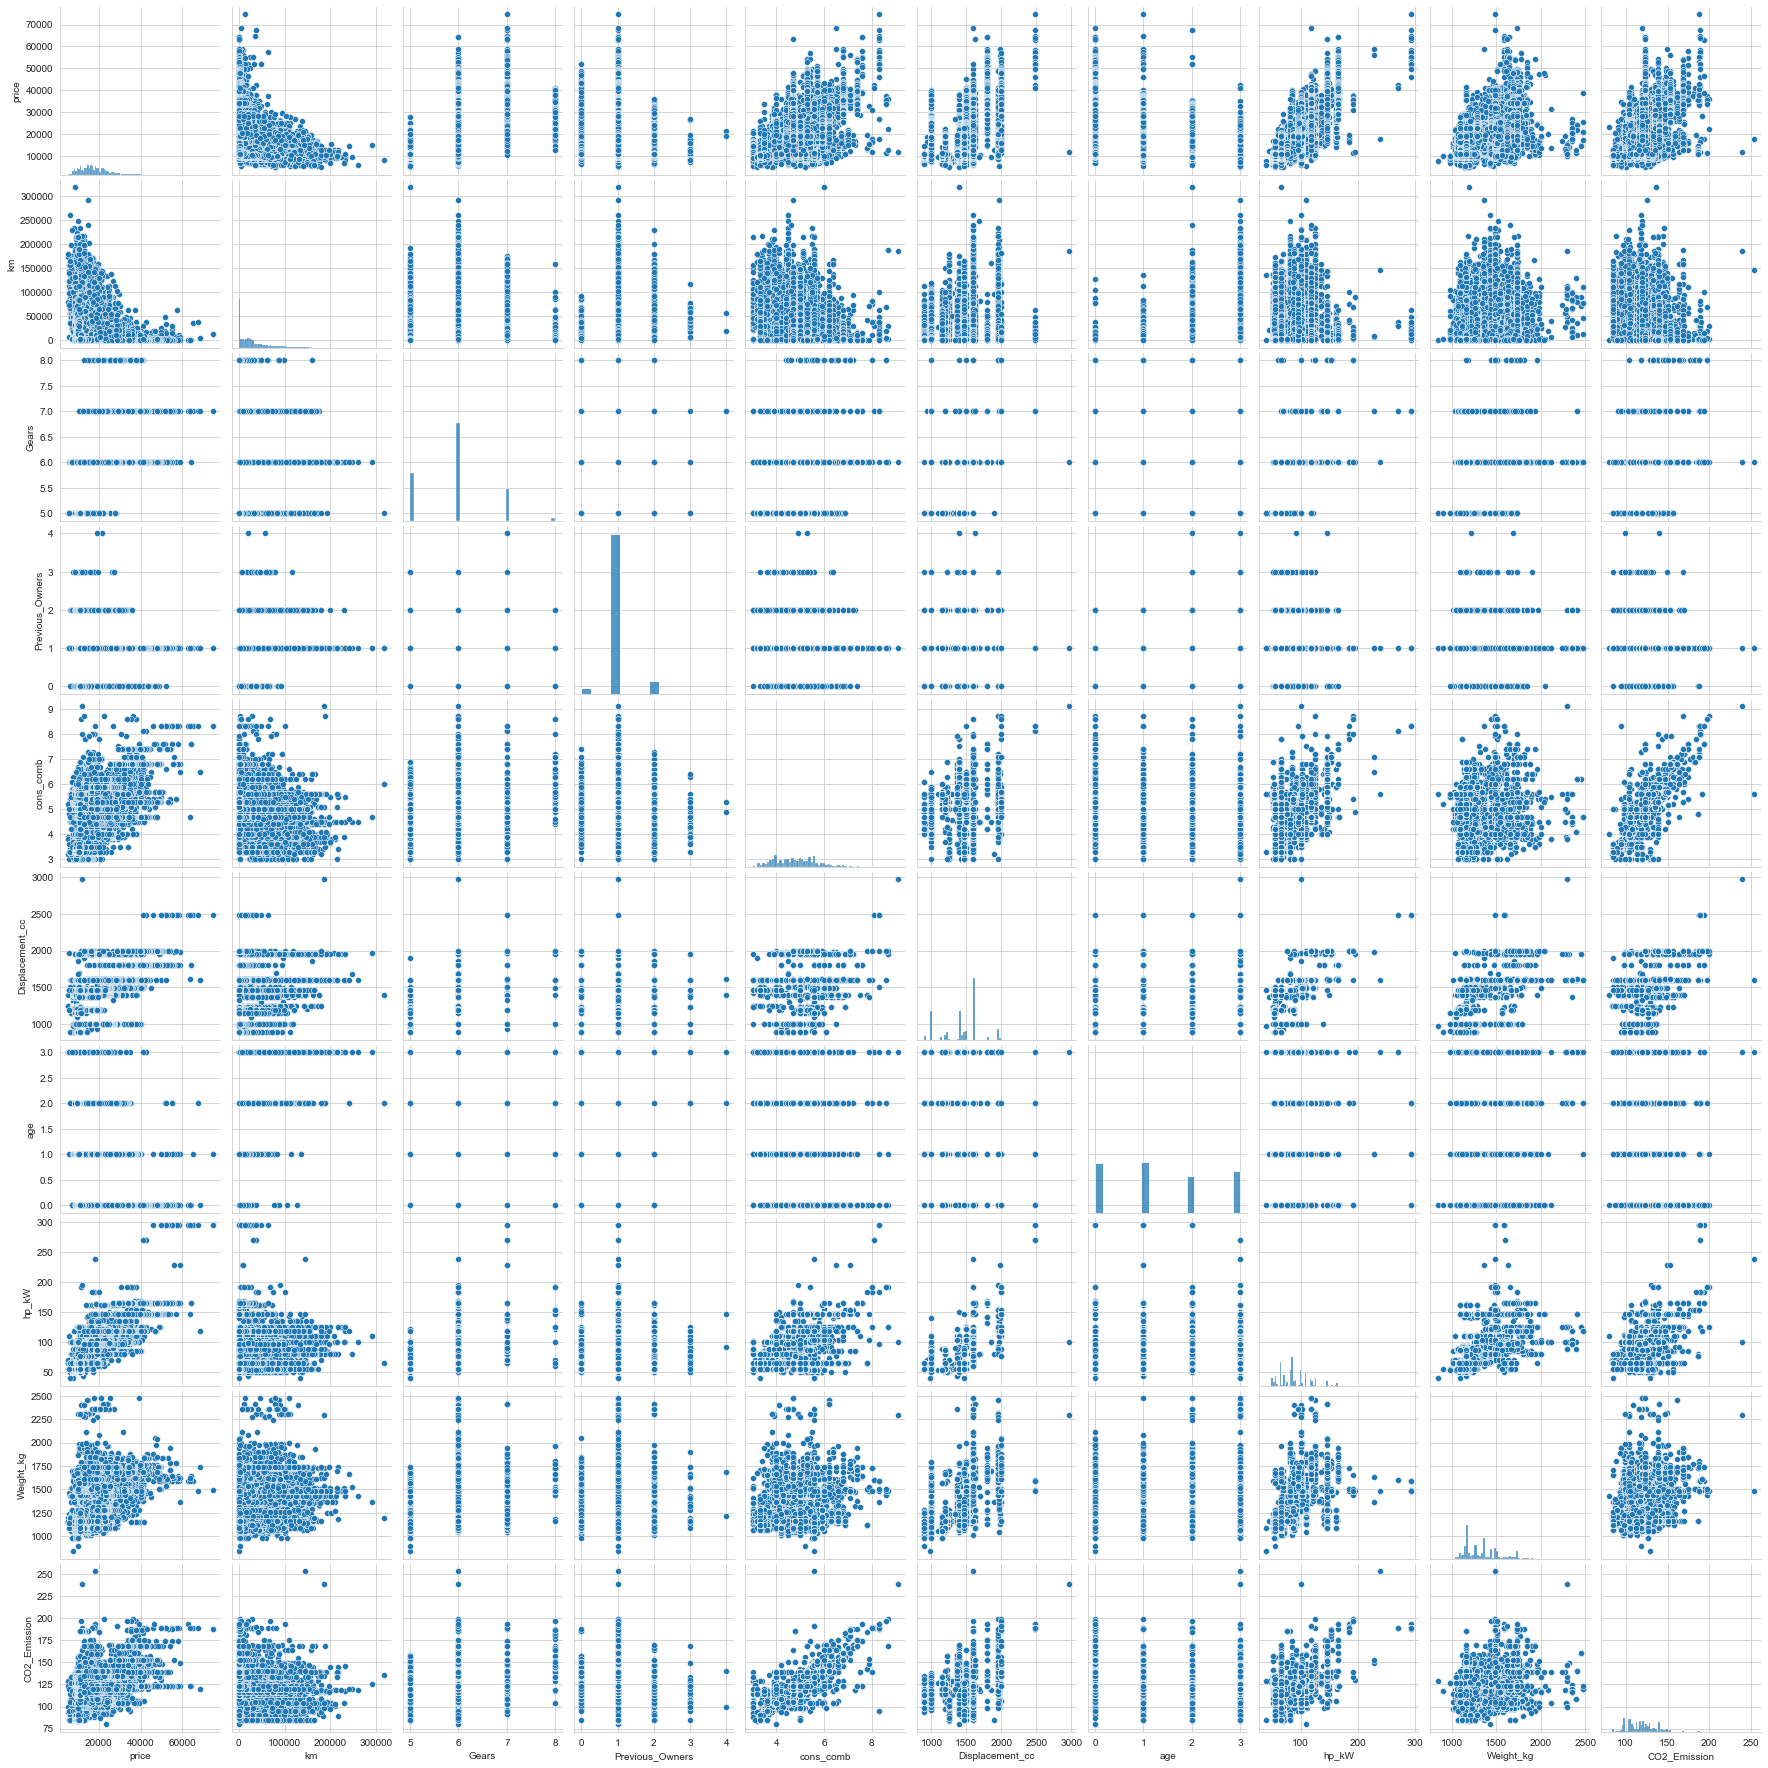

In [79]:
sns.pairplot(df_num, size = 2.5)
plt.show()

## Dummy Operation

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15914 entries, 0 to 15913
Data columns (total 24 columns):
make_model             15914 non-null object
body_type              15914 non-null object
price                  15914 non-null int64
vat                    15914 non-null object
km                     15914 non-null float64
Type                   15914 non-null object
Fuel                   15914 non-null object
Gears                  15914 non-null float64
Comfort_Convenience    15914 non-null object
Entertainment_Media    15914 non-null object
Extras                 15914 non-null object
Safety_Security        15914 non-null object
age                    15914 non-null float64
Previous_Owners        15914 non-null float64
hp_kW                  15914 non-null float64
Inspection_new         15914 non-null int64
Paint_Type             15914 non-null object
Upholstery_type        15914 non-null object
Gearing_Type           15914 non-null object
Displacement_cc        15914 non-

In [81]:
df.shape

(15914, 24)

In [82]:
df.to_csv("final_scout_not_dummy.csv", index=False)

In [83]:
df = df.join(df["Comfort_Convenience"].str.get_dummies(sep = ",").add_prefix("cc_"))
df = df.join(df["Entertainment_Media"].str.get_dummies(sep = ",").add_prefix("em_"))
df = df.join(df["Extras"].str.get_dummies(sep = ",").add_prefix("ex_"))
df = df.join(df["Safety_Security"].str.get_dummies(sep = ",").add_prefix("ss_"))

In [84]:
df.drop(["Comfort_Convenience","Entertainment_Media","Extras","Safety_Security"], axis=1, inplace=True)

In [85]:
df.shape

(15914, 114)

In [86]:
df_final = pd.get_dummies(df, drop_first=True)

In [87]:
df_final.shape

(15914, 134)

In [88]:
df_final.head().T

,0,1,2,3,4
price,15770.000,14500.000,14640.000,14500.000,16790.000
km,56013.000,80000.000,83450.000,73000.000,16200.000
Gears,7.000,7.000,7.000,6.000,7.000
age,3.000,2.000,3.000,3.000,3.000
Previous_Owners,2.000,1.000,1.000,1.000,1.000
hp_kW,66.000,141.000,85.000,66.000,66.000
Inspection_new,1.000,0.000,0.000,0.000,1.000
Displacement_cc,1422.000,1798.000,1598.000,1422.000,1422.000
Weight_kg,1220.000,1255.000,1135.000,1195.000,1135.000
cons_comb,3.800,5.600,3.800,3.800,4.100


In [89]:
df_final.to_csv("final_scout_dummy.csv", index=False)

### mehmetfatihdata